# Projeto 1 - Confiabilidade

## Autores

- D. H. Lelis - 12543822

## Orientações

Boa parte do código fonte foi organizado dentro de um módulo chamado `common`, disponibilizado juntamente ao notebook.
Alguns tópicos de atenção:

- **Dependências**
  - Neste notebook tem um bloco de código comentado que serve para instalar automaticamente as dependências, recomenda-se
    criar um ambiente virtual e instalá-las desta forma.
  - Caso crie uma venv, não esqueça de instalar o `jupyter` e/ou `ipykernel`.
  - **Importante:** *Nem todas as dependências utilizadas são comumente disponibilizadas
    em ambientes de execução como Google Colaboratory ou Anaconda.*
- **Configuração**
  - Caso seja necessário, é possível adequar algumas configurações para seu ambiente de execução (verificar `common/consts.py`
    e o bloco *"Configuração"*)
- **Simulações**
  - Por questões de performance, testamos desenvolver o simulador em algumas tecnologias. A versão mais completa e performática
    é a feita em *rust*, disponível em `/simulators/rust`, porém a versão em *Python*, principalmente usando *pypy*, consegue
    "quebrar o galho", estando disponível em `/simulators/python`.
  - Os resultados das simulações são armazenados em arquivos `.json` dentro da pasta `/datasets`. O notebook pode chamar os simuladores
    para gerar novas simulações caso não exista uma simulação com os parâmetros determinados. O simulador utilizado pode ser definido
    através das configurações.

### Dependências

In [58]:
# Instalação de dependências (descomentar linhas abaixo para instalar)
import sys

# !"{sys.executable}" -m pip install --upgrade pip
# !"{sys.executable}" -m pip install --upgrade pandas
# !"{sys.executable}" -m pip install --upgrade numpy
# !"{sys.executable}" -m pip install --upgrade scipy
# !"{sys.executable}" -m pip install --upgrade sympy
# !"{sys.executable}" -m pip install --upgrade matplotlib
# !"{sys.executable}" -m pip install --upgrade seaborn
# !"{sys.executable}" -m pip install --upgrade plotly

In [59]:
# Carregamento das dependências utilizadas

import sys
import os
import json
import math
import collections
import importlib

import numpy as np
import scipy as sc
import scipy.stats as st
import sympy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from typing import List, Tuple, Callable, Dict

import statsmodels.api as sm
import pylab as py

### Constantes

Verificar o arquivo `common/consts.py` para mais detalhes.

### Utilidades

Verificar os códigos em `common/` para mais detalhes.

## Enunciado

### Projeto 1 - Confiabilidade

Um sistema requer $n$ máquinas para funcionar. Elas quebram, a cada unidade de tempo (um minuto), com
probabilidade $p_0$. Para garantir o funcionamento confiável do sistema, $s$ máquinas adicionais são mantidas para
reposição. Quando uma máquina quebra, ela é substituída por uma em bom estado e enviada para reparo. O
tempo de reparo de cada máquina  ́e $t_R$ (fixo).

Deseja-se estudar a variável aleatória “tempo de colapso” do sistema, isto  ́e, o tempo $T$ que o sistema funciona
até dever ser parado porque não há $n$ máquinas disponíveis. Quanto vale $E(T)$? Qual é a distribuição de $T$?
Como depende a variável $T$ do número de máquinas reserva $s$? Mais em concreto, quantas máquinas adicionais
são necessárias para que $\text{Prob}\{T < 10000\}$ seja menor que 1%?

Faixas sugeridas de valores: $n = 10 − 100$, $p_0 = 0.001 − 0.01$, $s = 10 − 100$.

1. Quais das perguntas acima conseguem responder analiticamente? Nos casos que possa, qual é o resultado?
2. Os resultados do simulador são consistentes com as estimações analíticas no caso $\beta = 0$?
3. No simulador, é fácil inserir a amostragem de outras variáveis aleatórias. Estudar por exemplo a variável $Z$ que
podemos chamar “tempo de alerta”, definido como o tempo em que o número de máquinas em reparação atinge
80% do valor disponível $s$ (ou outra porcentagem a escolher). Como é a distribuição de probabilidade de $Z$?
4. São $Z$ e $T$ variáveis independentes? É possível predizer em alguma medida o tempo de colapso uma vez que foi
atingido o tempo de alerta? Se uma parada ordenada do sistema requer o tempo $t_R$ , pode sugerir uma estratégia
de manejo que “garanta” chegar a parada ordenada com 99% de probabilidade?
1. É lógico que as máquinas envelheçam. A probabilidade de cada máquina de falhar pode crescer linearmente com
o tempo, seguindo $p(k) = p_0 + \beta t_{f}(k)$ onde $k$ identifica a máquina e $t_f(k)$ o tempo que ela leva em funcionamento
desde o  ́ultimo reparo. No caso de $β \ne 0$  ́e impossível realizar cálculos analíticos sobre a variável $T$. Para isto,
desenvolver um pequeno código de simulação do processo. Esse caso é mais complexo que o original, porque é
necessário armazenar informação específica para cada máquina (o tempo que leva trabalhando). Mesmo assim,
trata-se apenas de uma adequada combinação de variáveis Bernoulli que o computador sabe simular.

## Parte 1 - Modelo Analítico e Validação da Simulação

### Uma simplificação do problema

Para encontrarmos uma solução analítica do problema, sentimos a necessidade de fazer algumas simplificações no problema, sendo elas: $t_R = \infty$ e $\beta = 0$. Dadas essas simplificações, conseguimos modelar nosso problema na forma de uma distribuição binomial negativa.

A representação mais comum da binomial negativa é dada por:

$$
p_1(t; s, p) = \begin{pmatrix}t + s - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t}
$$

Essa representação mede, dado um número fixo $s$ de sucessos desejados e uma probabilidade $p$, a probabilidade de obtermos $t$ falhas até atingir o último sucesso desejado.

Sabendo disso, podemos fazer algumas adaptações para melhor encaixá-la no problema. Primeiramente, ao invés de medirmos o número de falhas, vamos medir o número total de eventos necessários. Além disso, estamos interessados no ponto crítico do sistema, ou seja, quando atingimos $s_0 + 1$ falhas:

$$
p_2(t; s_0, p) = p_1(t-s_0-1; s_0 + 1, p) = \begin{pmatrix}t - 1 \\ s_0 \end{pmatrix} p^{s_0 + 1} (1 - p)^{t - s_0 - 1}
$$

Além disso, notemos que o problema considera um conjunto de $n$ máquinas em funcionamento de maneira simultânea. Podemos representar isso fazendo um agrupamento de $n$ eventos na nossa PMF, ficando da seguinte forma: ($k$ é o $k$-ésimo ciclo de execução)

$$
p_3(k; n, s_0, p) = \sum^{n}_{i = 1} p_2(n \cdot (k - 1) + i; s_0, p)
$$

Uma representação alternativa do formulado em $p_3$ é utilizando a CDF da binomial negativa, que, quando adequada ao nosso problema, pode ser representada da seguinte forma:

$$
I_{1-p}(s_0 + 1, k \cdot n - (s_0 + 1) + 1) = I_{1-p}(s_0 + 1, k \cdot n - s_0)
$$

*Obs.: $I$ corresponde à função beta incompleta regularizada* 

Além disso, o valor estimado pode ser representado da seguinte forma:

$$
E = \frac{(1 - p)(s_0 + 1) + p(s_0 + 1)}{pn} 
$$

#### A Variável $Z$ (Tempo de Alerta)

Dentro das mesmas simplificações, conseguimos mostrar que a modelagem da variável $Z$ seguirá a mesma distribuição, só que que com $s_0' = \lceil 0.8 \cdot s_0 \rceil$. Uma ideia semelhante se aplica ao tempo esperado de colapso.

### Comparando a solução analítica com a simulação



In [60]:
from common.models import tnbinom # Solução analítica
from common.simulation import load_or_generate_simulation, build_pmf, sim_s_search # Simulação

In [61]:
def compare_model_and_sim(n: int, s: int, p: float):
    # Simulation
    sim_data = load_or_generate_simulation(1000000, n, p, s) # Load simulation data
    xs, sim_ys =  build_pmf(sim_data) # Build simulation PMF
    simulation_trace = go.Bar(name="Simulação", x=xs, y=sim_ys) # Create simulation plot

    # Model
    model_ys = tnbinom.pmf(xs, n, s, p) # Compute PMF for model at xs
    model_trace = go.Bar(name="Modelo", x=xs, y=model_ys) # Create model plot
    
    # Mean
    simulation_mean = np.mean(sim_data['results'])
    model_mean = tnbinom.mean(n, s, p)

    # Z Variable
    z_xs, sim_z_ys = build_pmf(sim_data, field='results_z')
    simulation_z_trace = go.Bar(name="Simulação Z", x=z_xs, y=sim_z_ys, visible='legendonly') # Create simulation plot for Z

    model_z_ys = tnbinom.pmf(z_xs, n, np.ceil(s * 0.8), p)
    model_z_trace = go.Bar(name="Modelo Z", x=z_xs, y=model_z_ys, visible='legendonly') # Create simulation plot for Z

    # Z-delta Variable
    delta_xs, sim_delta_ys = build_pmf(sim_data, field='results_delta')
    simulation_delta_trace = go.Bar(name="Simulação Delta", x=delta_xs, y=sim_delta_ys, visible='legendonly') 

    model_delta_ys = tnbinom.pmf(delta_xs, n, s - np.ceil(s * 0.8) - 1, p)
    model_delta_trace = go.Bar(name="Modelo Delta", x=delta_xs, y=model_delta_ys, visible='legendonly')

    # Create plot figure
    fig = go.Figure(data=[
        simulation_trace,
        model_trace,
        simulation_z_trace,
        model_z_trace,
        simulation_delta_trace,
        model_delta_trace,
    ])

    # Add mean v-line
    fig.add_vline(x=simulation_mean, line_width=3, line_dash="dash", line_color="orange", annotation_text='Valor esperado')

    # Customize plot
    fig.update_layout(barmode="group", title={
        'text': f"Modelo x Simulação: n={n}; s={s}; p={p}",
        'xanchor': 'center',
        'x': 0.5
        },
        template="plotly_dark",
                      xaxis_title="Tempo (k)",
                      yaxis_title="Densidade de Probabilidade")
    fig.show()

In [62]:
compare_model_and_sim(50, 25, 0.005)
compare_model_and_sim(100, 25, 0.007)
compare_model_and_sim(100, 40, 0.01)


TypeError: 'NoneType' object is not subscriptable

### Testes de Aderência e de Hipótese

#### Criando Modelos e Classes

##### Classe Simulação

In [ ]:
class Sim(dict):
    def __init__(self, content = {}) -> None:
        # Carregando e salvando os dados da simulação como um dicionário
        super().__init__(Sim.__prepare_content(content))

    def pmf (self, x : int) -> float:
        return float(self['pmf'][x])

    def cdf (self, x : int) -> float:
        return float(self['cdf'][x])

    @staticmethod
    def __prepare_content(content):
        # Copia profunda dos dados (demora mais, mas é mais seguro)
        #sim = copy.deepcopy(content)
        sim = content

        sim['name'] = f"n = {sim['configs']['n']}, p0 = {sim['configs']['p0']}, s0 = {sim['configs']['s0']}"

        # Criando uma lista ordenada de cada simulação
        sim['sorted'] = list(sorted(sim['results']))
        
        # Calculando a pmf
        sim['freq'] = [0] * (sim['sorted'][-1] + 1)
        sim['pmf'] = [0.0] * (sim['sorted'][-1] + 1)
        p_per_elem = 1 / len(sim['sorted'])

        for x in sim['sorted']:
            sim['pmf'][x] += p_per_elem
            sim['freq'][x] += 1  # calculando frequências

        # Calculando a cdf
        sim['cdf'] = [0] * (sim['sorted'][-1] + 1)

        for i in range(1, len(sim['pmf'])):
            sim['cdf'][i] = sim['pmf'][i] + sim['cdf'][i - 1]

        # Normalizando os resultados com np e realizando cálculos útes
        # N = len(sim['results'])
        sim['results_np'] = np.asarray(sim['sorted'])
        sim['mean'] = np.mean(sim['results_np'])
        sim['std'] = np.std(sim['results_np'], ddof=1)
        sim['normalized'] = (sim['results_np'] - sim['mean']) / (sim['std'])

        return sim

    # Agrupa frequências
    def group_freq(self, width : int = 5) -> list:
        return [sum(self['freq'][i : i + width]) for i in range(0, self['trial_count'], width)]

    # Distribui as frequências para atingir uma frequencia mínima não nula
    def distribute_freq(self, min_freq = 5):
        tc = self['trial_count'] # trial count
        fq = self['freq']
        table = []
        last_width = 0

        for width in range(1, tc):
            last_width = width
            table = self.group_freq(width)
            if min([x for x in table if x > 0]) >= min_freq:
                break
        
        self['freq_table'] = table
        return (last_width, table)


    # Retorna o valor crítico para o test ks.
    def ks_rc(self, ns : float):
        N = self['trial_count']
        
        suported_ns = [0.2, 0.1, 0.05, 0.01]
        base_value = [1.07, 1.22, 1.36, 1.63]

        try:
            base_value = base_value[suported_ns.index(ns)]
        except:
            raise Exception('Nível de significância não suportado, ecolha um entre: ' + str(suported_ns))

        if 35 >= N:
            raise Exception('O tamanho amotral da simulação é pequeno demais. Ele deve ser superior a 35.')
    
        return base_value / np.sqrt(N)


    @staticmethod
    def load_sims(dir_name, datasets_path='../datasets/'):
        target_dir = os.path.join(datasets_path, dir_name)
        sims = []
        for target in os.listdir(target_dir):
            target_path = os.path.join(target_dir, target)
            if not os.path.isfile(target_path):
                continue

            if target.endswith('.json'):
                with open(target_path, 'r') as fp:
                    sims.append(Sim(json.load(fp)))

        return sims

##### Classe Modelo

In [ ]:
from common.models import tnbinom_gen # Solução analítica

In [ ]:
class Model:

    def __init__(self, n : int, s0 : int, p0 : float) -> None:
        # Configurações
        self.n = int(n) # numero de máquinas
        self.s0 = int(s0) # número de máquinas reservas
        self.p0 = float(p0) # probabilidade de uma máquina quebrar em um turno
        self.configs = {
            'n': self.n,
            'p0': self.p0,
            's0': self.s0,
            'tr': 0,
            'beta': 0,
        }

        # Criando uma distribuição.
        self.tnbinom = tnbinom_gen(name='tnbinom')
        self.dist = st.nbinom(self.s0 + 1, self.p0)
        self.E = self.ppf(0.5)
        self.not_p0 = 1 - self.p0

        # Expressões
        k, t, i, n, s, p = sp.symbols("k t i n s p")
        self.EXP = {
            'cdf': sp.betainc_regularized(s + 1, k + 1, 0, p),
        }

        self.exp = {
            'cdf': self.EXP['cdf'].subs({'s': self.s0, 'p': self.p0}),
        }
        
        # Funções lambda úteis
        self.lambdas = {
            'cdf': sp.lambdify('k', self.exp['cdf']),
        }
        

    @property
    def mean(self):
        return 0.5 + self.tnbinom.mean(self.n, self.s0, self.p0)

    def ppf(self, x : float):
        return (self.dist.ppf(x) + self.s0) / self.n

    # pmf : probability mass function
    def quick_pmf(self, x : int) -> float:
        return self.cdf(x) - self.cdf(x - 1) if x > 0 else 0.0

    # cdf : cumulative distribution function
    def quick_cdf(self, x : int) -> float:
        return self.lambdas['cdf'](x * self.n)

    # pmf : probability mass function
    def pmf(self, x : int) -> float:
        return self.tnbinom.pmf(x, self.n, self.s0, self.p0)

    # cdf : cumulative distribution function
    def cdf(self, x : int) -> float:
        return self.tnbinom.cdf(x, self.n, self.s0, self.p0)

    # Realiza o teste ks
    def kstest(self, data, quick = True):
        # Se data for uma lista de simulações, faça o teste ks para cada uma delas
        if isinstance(data, list):
            return [self.kstest(sim) for sim in data]

        # Se data for uma simulação apenas, 
        sim = data

        # variáveis relevantes
        distancia_max = [0, 0] 
        x_anterior = 0 

        cdf_func = self.quick_cdf if quick else self.cdf

        # iterando por cada dado x
        for x in sim['sorted']:
            distancia = [0, 0] # distancia de cada iteração

            cdf_val = cdf_func(x)
            distancia[0] = abs(cdf_val - sim['cdf'][x])
            distancia[1] = abs(cdf_val - sim['cdf'][x_anterior])
            x_anterior = x

            distancia_max[0] = max(distancia_max[0], distancia[0])
            distancia_max[1] = max(distancia_max[1], distancia[1])

        return max(distancia_max)


#### Instanciado modelos e carregando dados

Considere as seguintes configurações do sistema:

$$ 
    A: \quad n = 50 \quad p_0 = 0.006 \quad s_0 = 10
    \\
    B: \quad n = 100 \quad p_0 = 0.01 \quad s_0 = 25
$$

Podemos usar as classes "Model" e "Sim" para comparar o modelo analítico com os dados obtidos na simulação.


In [ ]:
# Caregando as simulações
SIMS_A = Sim.load_sims('50-0_006-10')
SIMS_B = Sim.load_sims('100-0_01-25')

# Criando modelos
MODEL_A = Model(n = 50, p0 = 0.006, s0 = 10)
MODEL_B = Model(n = 100, p0 = 0.01, s0 = 25)

#### COMPARANDO OS MODELOS ÀS SIMULAÇÕES

Considere as seguintes configurações do sistema:

$$ 
    A: \quad n = 50 \quad p_0 = 0.006 \quad s_0 = 10
    \\
    B: \quad n = 100 \quad p_0 = 0.01 \quad s_0 = 25
$$

Podemos usar as classes "Model" e "Sim" para comparar o modelo analítico com os dados obtidos na simulação.


##### VIZUALIZANDO COMPARAÇÕES

COMPARANDO COM UMA NORMAL (QQ-PLOT)

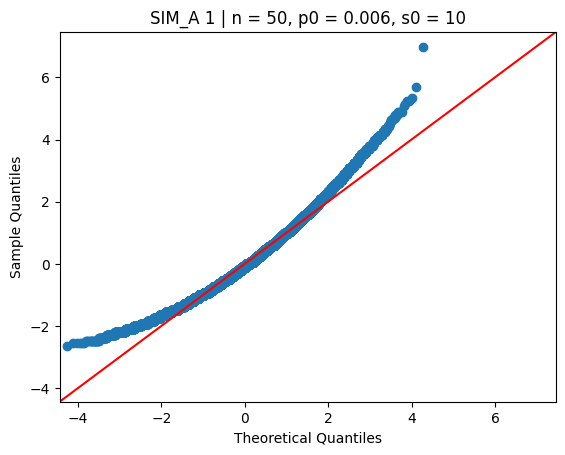

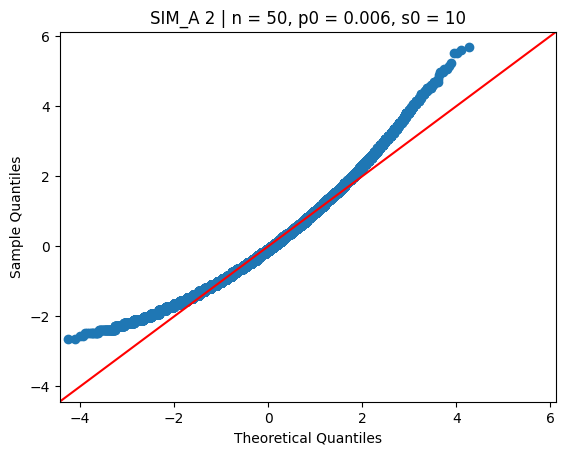

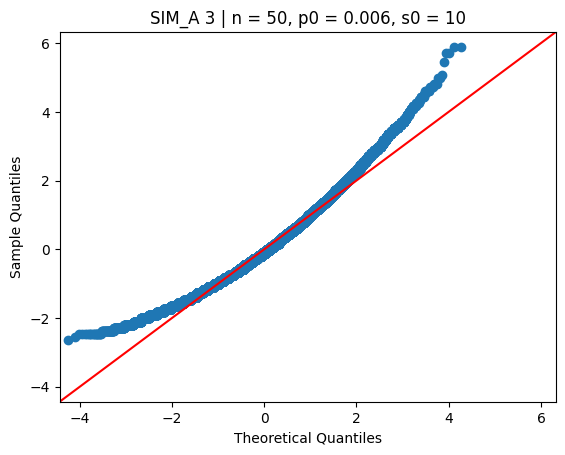

In [ ]:
for i, sim in enumerate(SIMS_A, start=1):
    sm.qqplot(sim['normalized'], line ='45')
    plt.title(f'SIM_A {i} | {sim["name"]}')
py.show()

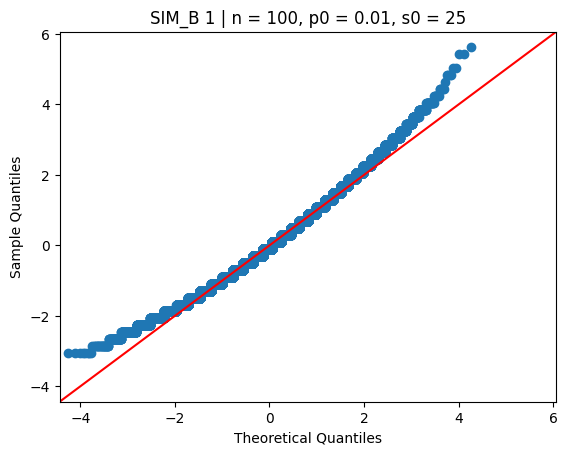

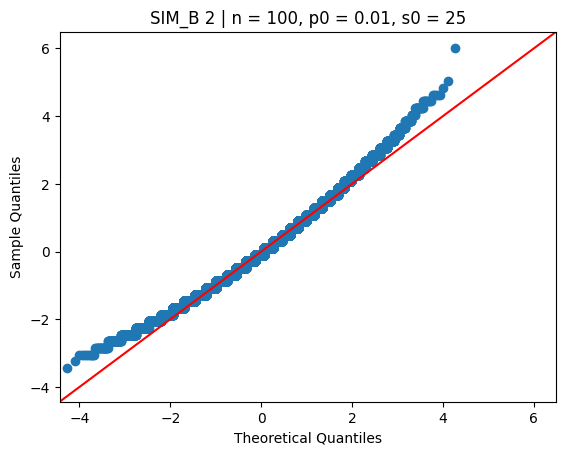

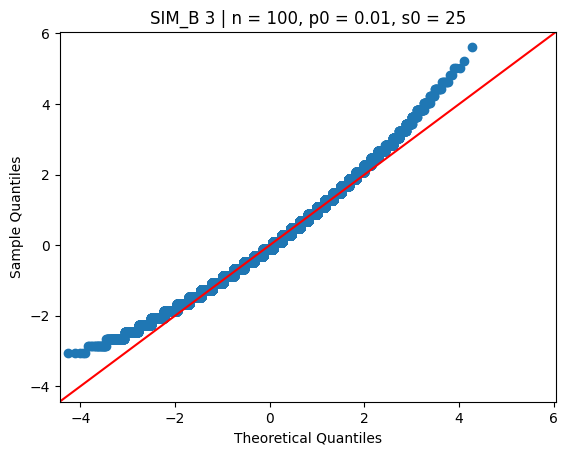

In [ ]:
for i, sim in enumerate(SIMS_B, start=1):
    sm.qqplot(sim['normalized'], line ='45')
    plt.title(f'SIM_B {i} | {sim["name"]}')
py.show()

**Conclusão:**

---

Os dados não seguem uma distribuição normal.

COMPARANDO COM O MODELO (QQ-PLOT)

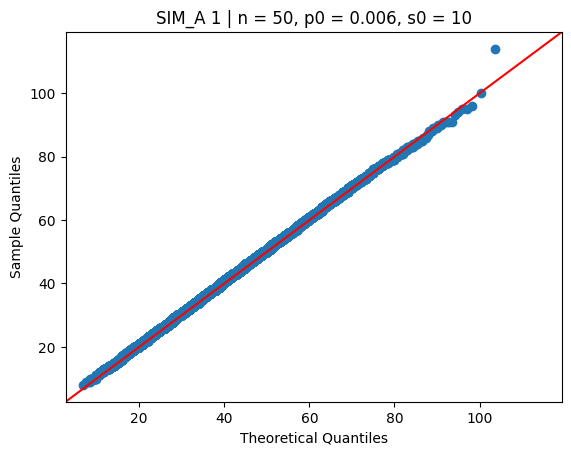

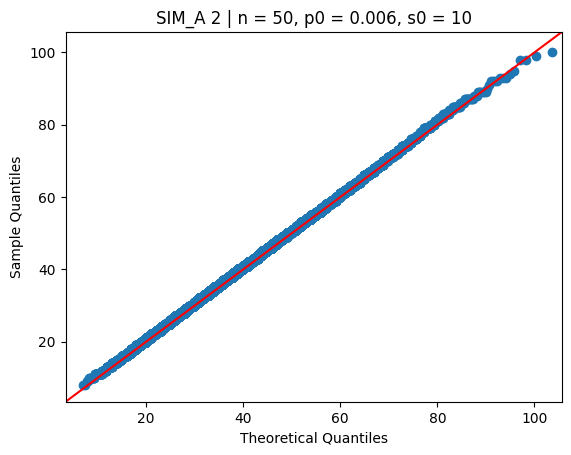

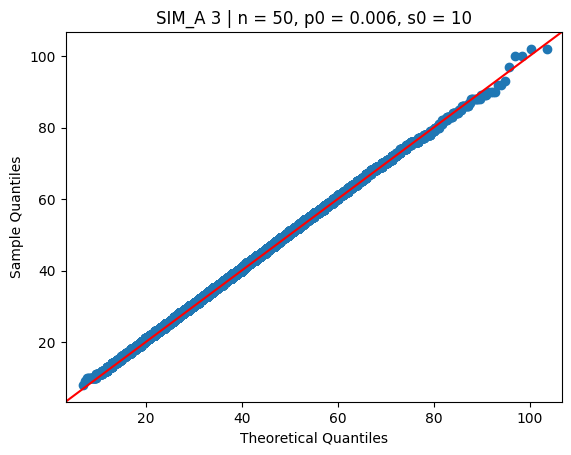

In [ ]:
for i, sim in enumerate(SIMS_A, start=1):
    sm.qqplot(sim['results_np'], dist=MODEL_A, line ='45')
    plt.title(f'SIM_A {i} | {sim["name"]}')
py.show()

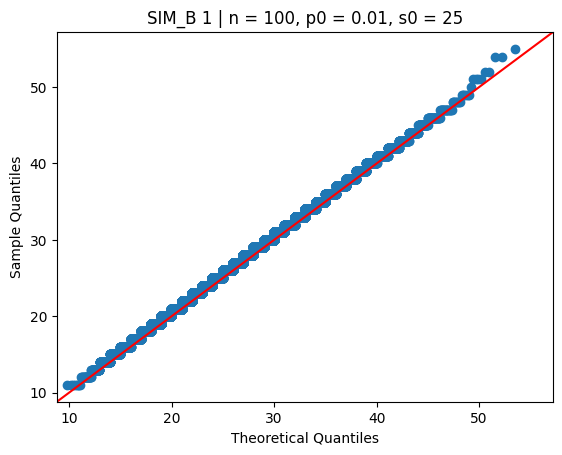

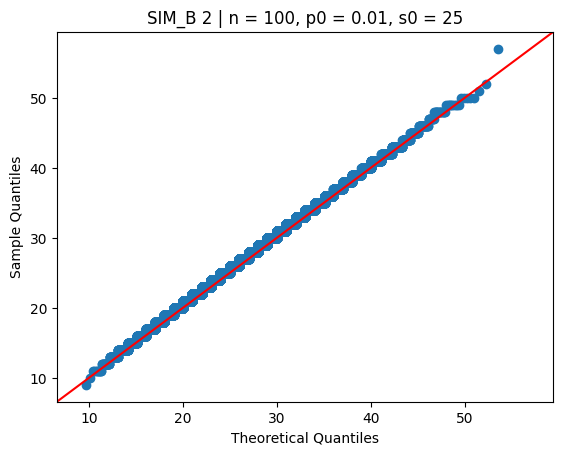

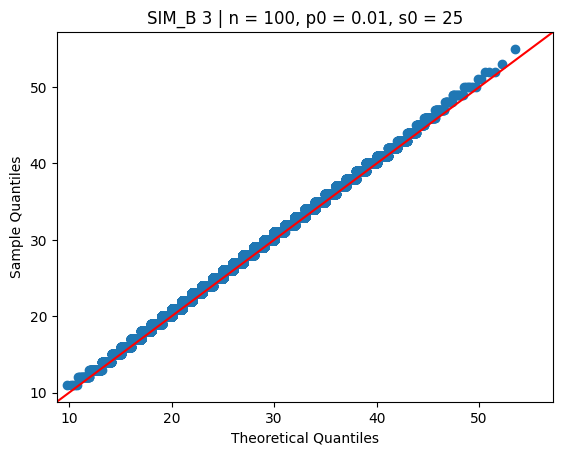

In [ ]:
for i, sim in enumerate(SIMS_B, start=1):
    sm.qqplot(sim['results_np'], dist=MODEL_B, line ='45')
    plt.title(f'SIM_B {i} | {sim["name"]}')
py.show()

**Conclusão:**

---

Os dados seguem uma distribuição binomial negativa.

#### DISTRIBUIÇÃO DA MÉDIA AMOSTRAL

In [ ]:
# MÉDIAS OBSERVADAS
A_xb = [sim['mean'] for sim in SIMS_A]
B_xb = [sim['mean'] for sim in SIMS_B]

print('MÉDIAS OBSERVADAS:')
print(f'A ({SIMS_A[0]["name"]}): ' + str(A_xb))
print(f'B ({SIMS_B[0]["name"]}): ' + str(B_xb))

# MÉDIAS TEÓRICAS
print('\nMédias esperadas:')
print(SIMS_A[0]['name'], ': ', str(MODEL_A.mean))
print(SIMS_B[0]['name'], ': ', str(MODEL_B.mean))

MÉDIAS OBSERVADAS:
A (n = 50, p0 = 0.006, s0 = 10): [37.1967, 37.20629, 37.15617]
B (n = 100, p0 = 0.01, s0 = 25): [26.50959, 26.48403, 26.48708]

Médias esperadas:
n = 50, p0 = 0.006, s0 = 10 :  37.166666666666664
n = 100, p0 = 0.01, s0 = 25 :  26.5


#### TESTE KS

##### A NOSSA IMPLEMENTAÇÃO

In [ ]:
# REGIÃO CRÍTICA
[(ns, SIMS_A[0].ks_rc(ns)) for ns in [0.2, 0.1, 0.05, 0.01]]

[(0.2, 0.0033836370963801657),
 (0.1, 0.0038579787454054225),
 (0.05, 0.0043006976178289955),
 (0.01, 0.005154512586074457)]

In [ ]:
MODEL_A.kstest(SIMS_A, quick=True)

[0.0476404008342175, 0.04810040083421735, 0.04563625744204153]

In [ ]:
MODEL_A.kstest(SIMS_A, quick=False)

[0.0476404008342175, 0.04810040083421735, 0.04563625744204153]

In [ ]:
MODEL_B.kstest(SIMS_B, quick=True)

[0.10245122665305345, 0.10181864005192842, 0.10060864005192921]

In [ ]:
MODEL_A.kstest(SIMS_A, quick=False)

[0.0476404008342175, 0.04810040083421735, 0.04563625744204153]

##### USANDO O SCIPY

In [ ]:
[st.kstest(sim['results'], MODEL_A.quick_cdf) for sim in SIMS_A]

[KstestResult(statistic=0.04764040083421206, pvalue=1.1284697961460565e-197),
 KstestResult(statistic=0.048100400834212076, pvalue=1.67158763355345e-201),
 KstestResult(statistic=0.045636257442037365, pvalue=2.0237253653835815e-181)]

In [ ]:
[st.kstest(sim['results'], MODEL_B.quick_cdf) for sim in SIMS_B]

[KstestResult(statistic=0.10245122665307721, pvalue=0.0),
 KstestResult(statistic=0.10181864005195063, pvalue=0.0),
 KstestResult(statistic=0.10060864005195064, pvalue=0.0)]

In [ ]:
[st.kstest(sim['results'], MODEL_A.cdf) for sim in SIMS_A]

[KstestResult(statistic=0.03938063644691947, pvalue=3.4648559474985527e-135),
 KstestResult(statistic=0.039840636446919486, pvalue=2.3553500143247565e-138),
 KstestResult(statistic=0.03748298169125758, pvalue=1.651317119030807e-122)]

In [ ]:
[st.kstest(sim['results'], MODEL_B.cdf) for sim in SIMS_B]

[KstestResult(statistic=0.08218697479709897, pvalue=0.0),
 KstestResult(statistic=0.08104791059468436, pvalue=0.0),
 KstestResult(statistic=0.07983791059468437, pvalue=0.0)]

#### DISTRIBUIÇÃO DA MÉDIA

In [ ]:
# MÉDIAS OBSERVADAS
MEANS_A = [sim['mean'] for sim in SIMS_A]
MEANS_B = [sim['mean'] for sim in SIMS_B]

print('Médias observadas:')
print(SIMS_A[0]['name'], ': ', str(MEANS_A))
print(SIMS_B[0]['name'], ': ', str(MEANS_B))

# MÉDIAS TEÓRICAS
print('\nMédias esperadas:')
print(SIMS_A[0]['name'], ': ', str(MODEL_A.mean))
print(SIMS_B[0]['name'], ': ', str(MODEL_B.mean))


Médias observadas:
n = 50, p0 = 0.006, s0 = 10 :  [37.1967, 37.20629, 37.15617]
n = 100, p0 = 0.01, s0 = 25 :  [26.50959, 26.48403, 26.48708]

Médias esperadas:
n = 50, p0 = 0.006, s0 = 10 :  37.166666666666664
n = 100, p0 = 0.01, s0 = 25 :  26.5


Considerando uma média amostral $\overline x$, dado a média  teórica $\mu$. Como temos um tamanho amostral muito grande, podemos aplicar o teorema central do limite e assumir que 
$$\frac {\overline x - \mu} {\frac {\sigma} {\sqrt{N}}} \sim N(0, 1) $$

\begin{cases}
    h_0: \, \mu = \overline x 
    \\
    h_a: \, \mu \ne \overline x
\end{cases}

In [ ]:
SIMS = {'A': SIMS_A, 'B': SIMS_B}
k = ['A', 'B']

# Preparando os dados
xb = {k: [sim['mean'] for sim in SIMS[k]] for k in k}
mu = {'A': MODEL_A.mean, 'B': MODEL_B.mean,}
s = {k: [sim['std'] for sim in SIMS[k]] for k in k}
N = SIMS_A[0]['trial_count'] # Todas as simulações tem mesmo tamanho amostral

# Calculando as estatísticas dos testes
z = {k: [(xb - mu[k]) / (s / np.sqrt(N)) for xb, s in zip(xb[k], s[k])] for k in k}

print('Estatísticas dos testes:')
print(z)

Estatísticas dos testes:
{'A': [0.8623337576482488, 1.1361187007788298, -0.30157263650121224], 'B': [0.598029019989938, -0.9947099398349899, -0.8032410637462374]}


In [ ]:
pval = {k: [2 * st.norm(0, 1).cdf(-abs(z)) for z in z[k]] for k in k}
pval

{'A': [0.38850388139707426, 0.2559068894370421, 0.7629778702453133],
 'B': [0.5498205697165044, 0.31987735870003087, 0.42183541521739365]}

In [ ]:
print('P-Valor:')

print('\tA:')
for i, v in enumerate(pval['A'], start = 1):
    print('\t\t{}: {}'.format(i, v))

print('\tB:')
for i, v in enumerate(pval['B'], start = 1):
    print('\t\t{}: {}'.format(i, v))

P-Valor:
	A:
		1: 0.38850388139707426
		2: 0.2559068894370421
		3: 0.7629778702453133
	B:
		1: 0.5498205697165044
		2: 0.31987735870003087
		3: 0.42183541521739365


Conclusão: aceitamos a hipótese nula dentro de uma margem de confiança:

In [ ]:
alpha = 0.05
t = st.t(N - 1).ppf(alpha / 2)

E = {k: [abs(t * s / np.sqrt(N)) for s in s[k]] for k in k}
E

{'A': [0.06826239102280804, 0.06835663053609767, 0.06822017367995474],
 'B': [0.031430384628904656, 0.031467468494692626, 0.03152607894112176]}

In [ ]:
ic = {k: [(xb - E, xb + E) for xb, E in zip(xb[k], E[k])] for k in k}
ic

{'A': [(37.128437608977194, 37.264962391022806),
  (37.1379333694639, 37.274646630536104),
  (37.08794982632005, 37.22439017367996)],
 'B': [(26.478159615371094, 26.541020384628904),
  (26.452562531505308, 26.515497468494694),
  (26.455553921058875, 26.518606078941122)]}

In [ ]:
print('Intervalos de confiança:')

print('\tA:')
for i, v in enumerate(ic['A'], start = 1):
    print('\t\t{}: {} - {}'.format(i, v[0], v[1]))

print('\tB:')
for i, v in enumerate(ic['B'], start = 1):
    print('\t\t{}: {} - {}'.format(i, v[0], v[1]))

Intervalos de confiança:
	A:
		1: 37.128437608977194 - 37.264962391022806
		2: 37.1379333694639 - 37.274646630536104
		3: 37.08794982632005 - 37.22439017367996
	B:
		1: 26.478159615371094 - 26.541020384628904
		2: 26.452562531505308 - 26.515497468494694
		3: 26.455553921058875 - 26.518606078941122


### Análise da Simulação Completa

Vamos agora sair da validação e solução analítica e partir para cenários mais reais, com tempo de reparo das máquinas e um crescimento da chance de quebra ao longo do tempo. Além disso, procuraremos encontrar quantidades de máquinas reservas necessárias para garantir um tempo mínimo de operação do sistema.

In [ ]:
# sim_s_search(100, 0.001, 38, 0.0001, 40, 80)
demo1_s, demo1_reduced_sim = sim_s_search(100, 0.001, 12, 0.001, 0, 100, trials=1000, verbose=True)
demo1_s
# demo1_complete_sim = load_or_generate_simulation(10000, 100, 0.001, demo1_s, 12, 0.001, max_cycles=100000)

Trying 50


TypeError: 'NoneType' object is not subscriptable

In [ ]:

n = 100
p = 0.001
ss = [35, 40, 45, 50, 55, 60]
tr = 12
beta = 0.001
max_cycles = 100000
bin_size = 10

traces = []

for s in ss:
    print(f"Loading simulation for s={s}")
    sim = load_or_generate_simulation(10000, n, p, s, tr, beta, max_cycles=max_cycles)
    simulation_trace = go.Histogram(name=f"Simulação s={s}", x=sim['results'], histnorm='probability density', xbins={
        'start': 0,
        'end': max_cycles,
        'size': bin_size
    })
    traces.append(simulation_trace)


fig = go.Figure(data=traces)

# Customize plot
fig.update_layout(barmode="group", title={
    'text': f"Modelo x Simulação: n={n}; s={s}; p={p}",
    'xanchor': 'center',
    'x': 0.5
    },
    template="plotly_dark",
                    xaxis_title="Tempo (k)",
                    yaxis_title="Densidade de Probabilidade")
fig.update_yaxes(autorange=True)
fig.show()



Loading simulation for s=35
Loading simulation for s=40
Loading simulation for s=45
Loading simulation for s=50
Loading simulation for s=55
Loading simulation for s=60
